In [2]:
pip install livelossplot

Note: you may need to restart the kernel to use updated packages.


In [3]:
#importing libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.14.0
GPU detected: []


In [6]:
#importing dataset
data = pd.read_csv(r"C:\Users\SOUMIK\Desktop\CNER Project\archive\ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [7]:
#finding the number of unique words and tags in the corpus
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [8]:
#padding the de-duplicated values
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [9]:
#padding for tags
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [10]:
print(num_words, num_tags)

35179 17


In [11]:
#Retrieve Sentences and Corresponding Tags
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [12]:
getter = SentenceGetter(data)
sentences = getter.sentences
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [14]:
#Define Mappings between Sentences and Tags
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
word2idx

{'Australia': 1,
 'repeating': 2,
 'Edwin': 3,
 'referring': 4,
 'royal': 5,
 'repeated': 6,
 'militancy': 7,
 'Casablanca': 8,
 'life-prolonging': 9,
 'jail': 10,
 '27,000': 11,
 'less-developed': 12,
 'Hardline': 13,
 'Snyder': 14,
 'docked': 15,
 'GAO': 16,
 'attractive': 17,
 'inhuman': 18,
 'procedures': 19,
 'Kazakhs': 20,
 'ai': 21,
 'Mahara': 22,
 'withdraw': 23,
 'uncle': 24,
 'small-cell': 25,
 '01-Jun': 26,
 'reopen': 27,
 'Jamaican-born': 28,
 'Alliance': 29,
 'convert': 30,
 '2,47,000': 31,
 'Named': 32,
 'crops': 33,
 'Abqaiq': 34,
 'Taji': 35,
 'evacuations': 36,
 'ant': 37,
 'gods': 38,
 'irrigated': 39,
 'mental': 40,
 'premature': 41,
 'States': 42,
 'Timothy': 43,
 'Yankees-Orioles': 44,
 'Joseph': 45,
 'Afghan': 46,
 '762.4': 47,
 'turmoil': 48,
 'Gulf-area': 49,
 'al-Jaafari': 50,
 'enter': 51,
 'jailbreak': 52,
 'initials': 53,
 'Amadou': 54,
 'Meishan': 55,
 'desecrated': 56,
 'Jerome': 57,
 'disdain': 58,
 'beset': 59,
 'comprise': 60,
 'Agent': 61,
 'curtailed'

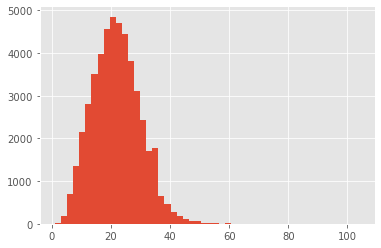

In [15]:
#creating histogram
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [16]:
#Padding Input Sentences and Creating Train/Test Splits
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [17]:
#splitting the data into 80-20
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [18]:
#creating bi-directional LSTM model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [19]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 50)            0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 50, 200)           120800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 17)            3417      
 ributed)                                                        
                                                             

In [20]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [21]:
#Train the Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

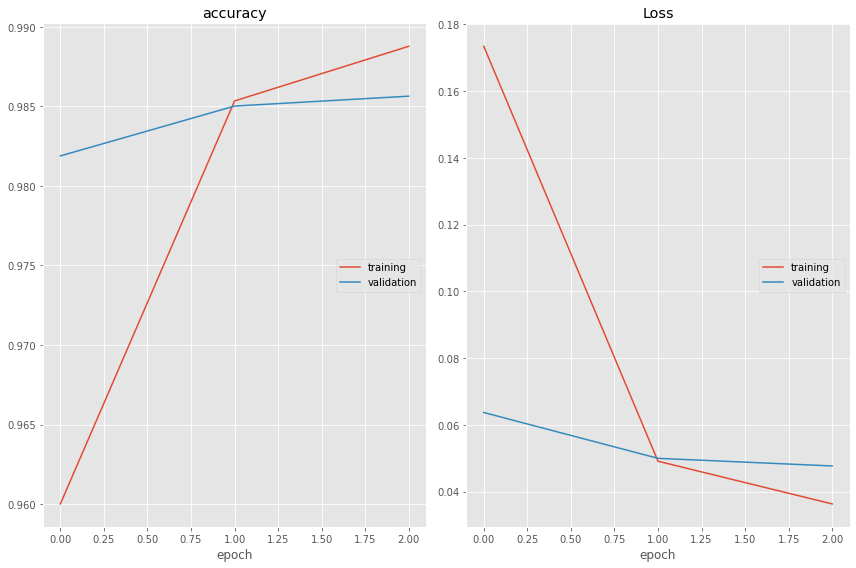

accuracy
	training         	 (min:    0.960, max:    0.989, cur:    0.989)
	validation       	 (min:    0.982, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.036, max:    0.173, cur:    0.036)
	validation       	 (min:    0.048, max:    0.064, cur:    0.048)

Epoch 3: val_loss improved from 0.04999 to 0.04771, saving model to model_weights.h5
1199/1199 [==============================] - 182s 151ms/step - loss: 0.0363 - accuracy: 0.9888 - val_loss: 0.0477 - val_accuracy: 0.9856
Wall time: 9min 17s


In [22]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

In [23]:
#Evaluate Named Entity Recognition Model
model.evaluate(x_test, y_test)

300/300 [==============================] - 9s 29ms/step - loss: 0.0477 - accuracy: 0.9856


[0.04770786687731743, 0.9856380224227905]

In [24]:
#Prediction
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 1s 945ms/step
Word           True 	 Pred

------------------------------
The            O	O
United         B-geo	B-geo
States         I-geo	I-geo
has            O	O
103            O	O
nuclear        O	O
power          O	O
plants         O	O
in             O	O
31             O	B-tim
states         O	O
.              O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek           O	O
Riek         